***🧠 Smart Image Processor with Edge & Logo Detection***

📤 Please upload an image of a face...


Saving 42-420483_will-smith.png to 42-420483_will-smith (2).png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


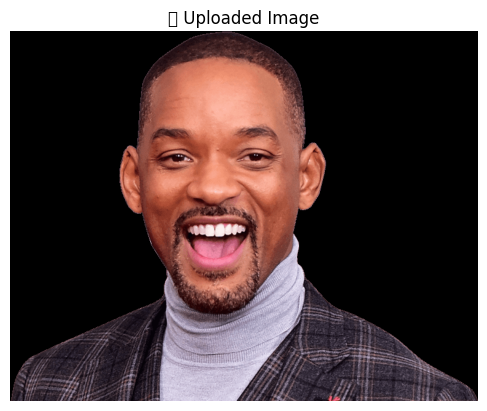

=== Image Processing System ===
[*] Image loaded successfully.
[*] Edge detection completed.


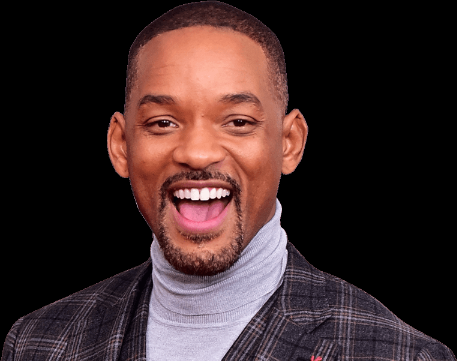

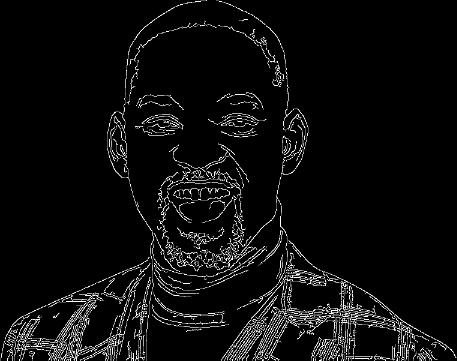

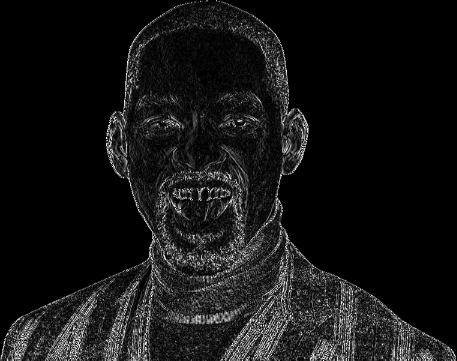

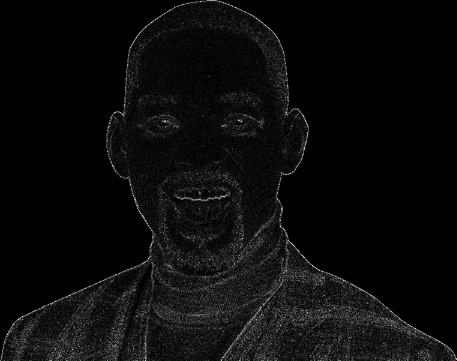

[*] Edge outputs saved to 'outputs/' folder.
Enter path to logo template (optional, press Enter to skip): /content/42-420483_will-smith (2).png


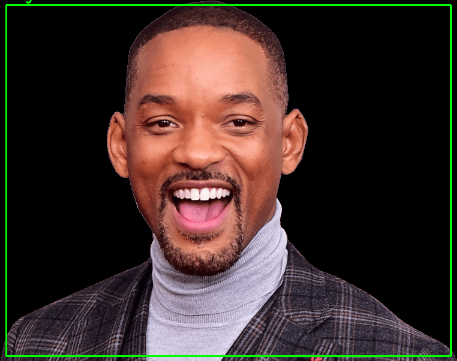

[+] Logo Detected!
[*] Invoice Check: Likely an Image (Landscape)
Press any key in image window to exit...


In [7]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
from google.colab import files
import matplotlib.pyplot as plt

print("📤 Please upload an image of a face...")
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.title("📸 Uploaded Image")
plt.show()

os.makedirs("outputs", exist_ok=True)

def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    canny = cv2.Canny(blurred, 50, 150)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return canny, sobelx, laplacian

def resize_display(image, scale=0.6):
    return cv2.resize(image, (0, 0), fx=scale, fy=scale)

def detect_logo(image, template_path, threshold=0.7):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template_orig = cv2.imread(template_path, 0)
    if template_orig is None:
        print("[!] Failed to load logo template. Check the path.")
        return image, False
    if gray_image.shape == template_orig.shape and np.array_equal(gray_image, template_orig):
        print("[-] Template is same as image. Skipping logo detection to avoid false match.")
        return image, False
    found = None
    for scale in np.linspace(0.5, 1.5, 20)[::-1]:
        template = cv2.resize(template_orig, (0, 0), fx=scale, fy=scale)
        tH, tW = template.shape[:2]
        if gray_image.shape[0] < tH or gray_image.shape[1] < tW:
            continue
        result = cv2.matchTemplate(gray_image, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        if found is None or max_val > found[0]:
            found = (max_val, max_loc, scale, tW, tH)
    if found and found[0] >= threshold:
        max_val, max_loc, scale, tW, tH = found
        top_left = max_loc
        bottom_right = (top_left[0] + tW, top_left[1] + tH)
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
        cv2.putText(image, "Logo Detected", (top_left[0], top_left[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        return image, True
    return image, False

def detect_invoice(image):
    height, width = image.shape[:2]
    return "Likely a Document (Portrait)" if height > width else "Likely an Image (Landscape)"

def main():
    print("=== Image Processing System ===")

    # Use the uploaded image path directly
    image_path = img_path
    image = img

    print("[*] Image loaded successfully.")

    canny, sobelx, laplacian = detect_edges(image)
    print("[*] Edge detection completed.")

    cv2_imshow(resize_display(image))
    cv2_imshow(resize_display(canny))
    cv2_imshow(resize_display(np.uint8(np.absolute(sobelx))))
    cv2_imshow(resize_display(np.uint8(np.absolute(laplacian))))

    cv2.imwrite("outputs/canny.jpg", canny)
    cv2.imwrite("outputs/sobelx.jpg", np.uint8(np.absolute(sobelx)))
    cv2.imwrite("outputs/laplacian.jpg", np.uint8(np.absolute(laplacian)))

    print("[*] Edge outputs saved to 'outputs/' folder.")

    template_path = input("Enter path to logo template (optional, press Enter to skip): ").strip()
    if template_path:
        if not os.path.exists(template_path):
            print("[!] Logo template not found. Skipping logo detection.")
        else:
            image_with_logo, found = detect_logo(image.copy(), template_path)
            cv2_imshow(resize_display(image_with_logo))
            cv2.imwrite("outputs/logo_detected.jpg", image_with_logo)
            print("[+] Logo Detected!" if found else "[-] Logo not detected.")
    else:
        print("[-] Skipped logo detection.")

    print("[*] Invoice Check:", detect_invoice(image))
    print("Press any key in image window to exit...")
    try:
        cv2.waitKey(0)
    finally:
        cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
